In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tensorflow version: 2.2.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive"

df = pd.read_csv('/content/drive/My Drive/S&P_500_Index_Data.csv', parse_dates=['date'])

In [4]:
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [3]:
df.shape

(8192, 2)

In [5]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close,
                    mode='lines',
                    name='close'))
fig.update_layout(showlegend=True)
fig.show()

In [6]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [9]:
time_steps = 30

X_train, y_train = create_dataset(train[['close']], train.close, time_steps)
X_test, y_test = create_dataset(test[['close']], test.close, time_steps)

print(X_train.shape)

(6523, 30, 1)


In [10]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [12]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
184/184 [==============================] - 2s 11ms/step - loss: 0.1650 - val_loss: 0.1764
Epoch 2/100
184/184 [==============================] - 1s 7ms/step - loss: 0.1136 - val_loss: 0.0569
Epoch 3/100
184/184 [==============================] - 1s 7ms/step - loss: 0.0902 - val_loss: 0.0510
Epoch 4/100
184/184 [==============================] - 1s 7ms/step - loss: 0.0806 - val_loss: 0.0539
Epoch 5/100
184/184 [==============================] - 1s 7ms/step - loss: 0.0763 - val_loss: 0.0447
Epoch 6/100
184/184 [==============================] - 1s 7ms/step - loss: 0.0778 - val_loss: 0.0468
Epoch 7/100
184/184 [==============================] - 1s 7ms/step - loss: 0.0753 - val_loss: 0.0776
Epoch 8/100
184/184 [==============================] - 1s 7ms/step - loss: 0.0766 - val_loss: 0.0388
Epoch 9/100
184/184 [==============================] - 1s 7ms/step - loss: 0.0715 - val_loss: 0.0291
Epoch 10/100
184/184 [==============================] - 1s 7ms/step - loss: 0.0730 - val_l

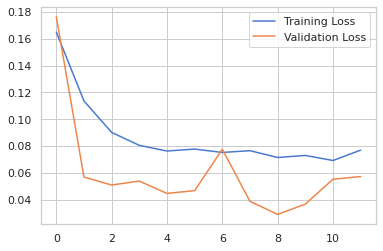

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [14]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [15]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 0s 4ms/step - loss: 0.3715


0.3715483844280243

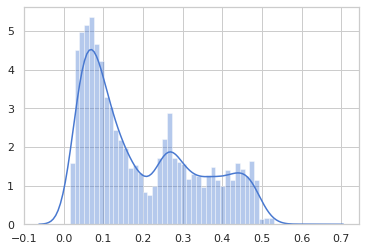

In [16]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [17]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

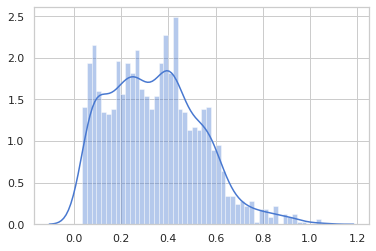

In [18]:
sns.distplot(test_mae_loss, bins=50, kde=True);

In [19]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [21]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.728849,0.65,True
7475,2015-08-26,2.632149,0.795943,0.65,True
7476,2015-08-27,2.745147,0.704524,0.65,True
7975,2017-08-21,3.801338,0.653309,0.65,True
7976,2017-08-22,3.859192,0.657245,0.65,True


In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()